In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import functools as ft
from tools import helpers as h
from copy import copy

from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from collections import OrderedDict
import torch
import torch.nn as nn
from sklearn.preprocessing import Normalizer

%matplotlib inline

In [2]:
louv = pd.read_csv('../data/cluster/louvain_clusters.txt', index_col=0, sep='\t')
louv.columns = ['cluster_super']
louv = louv.merge(pd.read_csv('../data/cluster/louvain_small_clusters.txt', index_col=0, sep='\t'), left_index=True, right_index=True)
louv.columns = ['cluster_super', 'cluster_sub']
louv.head()

,cluster_super,cluster_sub
names,,
MST1R,3,11
YES1,3,11
TYRO3,3,11
FGR,3,11
SRC,3,11


In [3]:
hgnc_mapper = h.fetch_hgnc_mapper()

In [4]:
# initial target list -- not for linear programming
klaeger = pd.read_excel('../data/ref/Klaeger_Science_2017 Supplementary Table 6 Selectivities.xlsx', sheet_name='CATDS target')

# a number of drugs have very similar targets listed in the same row
# we parse to separate these out 
double_drug_targets = klaeger[klaeger['Target'].apply(lambda x: ';' in x)]

# get the first and second gene
first_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[0])
second_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[1])

# fix the double targets
repaired_double_targets = double_drug_targets.drop('Target', axis=1).assign(**{'Target':first_genes})
repaired_double_targets = repaired_double_targets.append(double_drug_targets.drop('Target', axis=1).assign(**{'Target':second_genes})) 
klaeger = klaeger.drop(double_drug_targets.index).append(repaired_double_targets, sort=False)

# filter to only hgnc keys
klaeger = klaeger[klaeger.Target.isin(hgnc_mapper.keys())]

# convert to hgnc
klaeger.Target = klaeger.Target.apply(lambda x: hgnc_mapper[x])

# filter to our kinases
klaeger = klaeger[klaeger.Target.isin(set(louv.index))]

# save total drug list information
drug_list = list(sorted(set(klaeger.Drug)))
print(len(drug_list), ' drugs present for our analysis')

# sort columns
klaeger = klaeger[['Target', 'Drug', 'At', 'CATDS']]

klaeger['Drug'] = [x.lower().replace('-', '') for x in klaeger.Drug]
klaeger.head()

217  drugs present for our analysis


,Target,Drug,At,CATDS
0,AURKA,mk5108,0.120921,0.657165
1,CHEK1,pf477736,0.243725,0.733257
2,FLT3,dovitinib,0.265240,0.860803
4,MET,capmatinib,0.337514,1.000000
5,MAPKAPK2,vx702,0.342705,0.743594


In [5]:
klaeger_drugs = set(klaeger.Drug)
print(len(klaeger_drugs), 'drugs in the Klaeger 2017 Science Paper with known targets')

217 drugs in the Klaeger 2017 Science Paper with known targets


### Klaeger All hits data (4-cell line mix)

In [40]:
allhits = pd.read_excel('../data/ref/Klaeger_Science_2017 Supplementary Table 2 Target Lists.xlsx', sheet_name='Kinobeads')

allhits_double_drug_targets = allhits[allhits['Gene Name'].apply(lambda x: ';' in x)]

# get the first and second gene
allhits_first_genes = allhits_double_drug_targets['Gene Name'].apply(lambda x: x.split(';')[0])
allhits_second_genes = allhits_double_drug_targets['Gene Name'].apply(lambda x: x.split(';')[1])

# fix the double targets
allhits_repaired_double_targets = allhits_double_drug_targets.drop('Gene Name', axis=1).assign(**{'Gene Name':allhits_first_genes})
allhits_repaired_double_targets = allhits_repaired_double_targets.append(allhits_double_drug_targets.drop('Gene Name', axis=1).assign(**{'Gene Name':allhits_second_genes})) 
allhits = allhits.drop(allhits_double_drug_targets.index).append(allhits_repaired_double_targets, sort=False)

# filter to only hgnc keys
allhits = allhits[allhits['Gene Name'].isin(hgnc_mapper.keys())]

# convert to hgnc
allhits['Gene Name'] = allhits['Gene Name'].apply(lambda x: hgnc_mapper[x])

# filter to our kinases
allhits = allhits[allhits['Gene Name'].isin(set(louv.index))]

# lower drug names
allhits['Drug'] = [x.lower().replace('-', '') for x in allhits.Drug]

allhits.head()

,Drug,Lysate,Beads,Gene Name,Relative Intensity DMSO,Relative Intensity 3 nM,Relative Intensity 10 nM,Relative Intensity 30 nM,Relative Intensity 100 nM,Relative Intensity 300 nM,...,Bottom,Top,Inflection,EC50,EC50 Standard Error,Correction Factor,Apparent Kd,R2,BIC,Target Classification
0,abemaciclib,4 cell line mix,Kinobeads,AAK1,1,0.905556,0.791054,0.738292,0.639565,0.323354,...,0.009092,0.957905,151.288760,151.288760,45.696999,0.673073,101.828368,0.985386,-20.503519,High confidence
1,abemaciclib,4 cell line mix,Kinobeads,ADCK1,1,1.045974,0.869866,1.141565,0.000000,0.000000,...,-0.001200,1.014355,63.935536,63.935536,68.832970,0.622595,39.805937,0.983520,-12.606135,High confidence
2,abemaciclib,4 cell line mix,Kinobeads,BMP2K,1,1.101696,1.012297,1.087891,0.973740,0.863230,...,-1.003278,1.034558,84774.108960,84774.108960,217756.243215,0.660952,56031.642989,0.937247,-15.330485,High confidence
3,abemaciclib,4 cell line mix,Kinobeads,CAMK2D,1,0.894551,0.984481,0.900583,0.440384,0.178266,...,0.018690,0.972850,95.373379,95.373379,12.131433,0.203913,19.447883,0.992088,-22.486948,High confidence
4,abemaciclib,4 cell line mix,Kinobeads,CAMK2G,1,1.125435,1.565245,1.236451,0.315507,0.139777,...,0.043265,1.232332,82.363844,82.363844,NaN,0.217204,17.889794,0.939239,1.734623,High confidence


In [39]:
len(set(allhits.Drug))

220

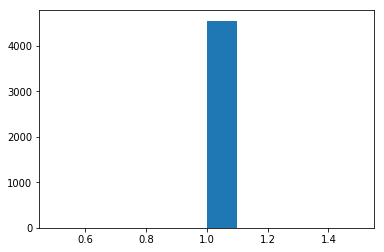

In [22]:
plt.hist(allhits['Relative Intensity DMSO'])
plt.show()

In [49]:
raw_conc_data = allhits[['Drug', 'Gene Name'] + [x for x in allhits.columns if 'Relative Intensity' in x and 'DMSO' not in x]]
raw_conc_data.head()

,Drug,Gene Name,Relative Intensity 3 nM,Relative Intensity 10 nM,Relative Intensity 30 nM,Relative Intensity 100 nM,Relative Intensity 300 nM,Relative Intensity 1000 nM,Relative Intensity 3000 nM,Relative Intensity 30000 nM
0,abemaciclib,AAK1,0.905556,0.791054,0.738292,0.639565,0.323354,0.181984,0.063421,0.057103
1,abemaciclib,ADCK1,1.045974,0.869866,1.141565,0.000000,0.000000,0.000000,0.000000,0.000000
2,abemaciclib,BMP2K,1.101696,1.012297,1.087891,0.973740,0.863230,0.885498,0.862572,0.313434
3,abemaciclib,CAMK2D,0.894551,0.984481,0.900583,0.440384,0.178266,0.021331,0.004220,0.017424
4,abemaciclib,CAMK2G,1.125435,1.565245,1.236451,0.315507,0.139777,0.013431,0.005382,0.017473


In [50]:
from numba import jit

@jit()
def gr(c, GRinf, GR50, GR_Hill_Coeff):
    # add eps for softening
    return GRinf + np.divide(1- GRinf, 1 + np.power(np.divide(c/(GEC50+1.e-20)), GR_Hill_Coeff)+1.e-20)

In [51]:
agg = pd.read_csv('../data/modelInputs/input_grMetrics.tsv', sep='\t', header=0, index_col=None)

# filter to high r2 values
agg = agg[agg['GR_r2'] > .6]
agg.head()

,molecule,cellline,GR50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,inf_50,missing_50,normal_50
0,seliciclib,bt20,1.898774,0.194160,-1.00000,1.17820,0.17548,0.97227,0.0,0.0,1.0
1,a443654,bt20,0.051675,-0.492210,-0.63357,0.55758,1.00120,0.98743,0.0,0.0,1.0
3,at7519,bt20,0.186015,-0.401780,-0.40563,1.32240,0.86351,0.99936,0.0,0.0,1.0
4,azd5438,bt20,0.219866,-0.354640,-0.44610,0.79155,0.74810,0.99091,0.0,0.0,1.0
5,azd6482,bt20,0.827110,-0.081485,-0.54825,0.76277,0.42682,0.99881,0.0,0.0,1.0


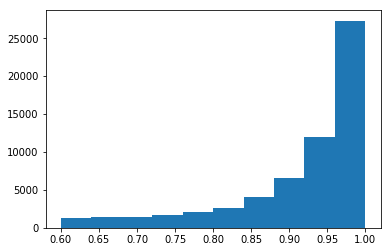

In [52]:
plt.hist(agg.GR_r2)
plt.show()

In [53]:
display(len(set(agg.molecule)& klaeger_drugs))
display(len(set(agg.molecule) & set(raw_conc_data.Drug)))

82

82

In [58]:
common_drugs = set(agg.molecule) & set(raw_conc_data.Drug)

In [59]:
agg = agg[agg.molecule.isin(common_drugs)]
conc_data = raw_conc_data[raw_conc_data.Drug.isin(common_drugs)]

In [ ]:
class custom_output(nn.Module):
    def __init__(self):
        super(custom_output, self).__init__()
        self.which_50_classifier = nn.Sequential(
            nn.Linear(20, 3),
            nn.Softmax(dim=1)
        )
        self.regressor_GR50 = nn.Sequential(
            nn.Linear(20, 1),
            nn.Softplus()
        )
        self.regressor_GR_max_inf_r2 = nn.Sequential(
            nn.Linear(20,3),
            nn.Tanh()
        )
        self.regressor_hGR = nn.Sequential(
            nn.Linear(20,1),
            nn.ReLU6()
        )
        self.regressor_GRaoc = nn.Sequential(
            nn.Linear(20,1),
            nn.LeakyReLU() # no CELU in 0.4 :( 
        )
    
    def forward(self, x):
        which_50 = self.which_50_classifier(x)
        gr50 = self.regressor_GR50(x)
        gr_max_inf_r2 = self.regressor_GR_max_inf_r2(x)
        hGR = self.regressor_hGR(x)
        GRaoc = self.regressor_GRaoc(x)
        
        return (which_50, gr50, gr_max_inf_r2, hGR, GRaoc)
        

In [84]:
class kin_encoder(nn.Module):
    def __init__(self, input_size, hidden_size=1, expand_rate=1., shrink_rate=0.5, min_width=5, noise=None):
        super(kin_encoder, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.shrink_rate = shrink_rate
        self.expand_rate = expand_rate
        self.min_width = min_width
        self.noise = noise
        
        self.BCE = nn.BCELoss(reduction=loss_reduc)
        
        self.max_size = int(input_size*self.expand_rate)
        
        self.encoder_base = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.ReLU(),
            nn.Linear(input_size, self.max_size),
            nn.ReLU(),
            nn.BatchNorm1d(self.max_size),
            nn.Linear(self.max_size, min(int(shrink_rate*self.max_size), min_width)),
            nn.ReLU(),
            nn.BatchNorm1d(min(int(shrink_rate*self.max_size), min_width)),
            nn.Linear(min(int(shrink_rate*self.max_size), min_width), min(int(shrink_rate*self.max_size**2), min_width)),
            nn.ReLU(),
        )
        
        self.encoder_mu = nn.Sequential(
            nn.BatchNorm1d(min(int(shrink_rate*self.max_size**2), min_width)),
            nn.Linear(min(int(shrink_rate*self.max_size**3), min_width), hidden_size)
        )
        
        self.encoder_logvar = nn.Sequential(
            nn.BatchNorm1d(min(int(shrink_rate*self.max_size**2), min_width)),
            nn.Linear(min(int(shrink_rate*self.max_size**3), min_width), hidden_size)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, min_width),
            nn.ReLU(),
            nn.BatchNorm1d(min_width),
            nn.Linear(min_width, min(int(shrink_rate*self.max_size**2), min_width)),
            nn.ReLU(),
            nn.BatchNorm1d(min(int(shrink_rate*self.max_size**2), min_width)),
            nn.Linear(min(int(shrink_rate*self.max_size**2), min_width), self.max_size),
            nn.ReLU(),
            nn.BatchNorm1d(self.max_size),
            nn.Linear(self.max_size, input_size),
            nn.ReLU(),
            nn.BatchNorm1d(input_size),
            nn.Linear(input_size)
        )
        
    def encode(self, x):
        h = self.encoder_base(x)
        return self.encoder_mu(h), self.encoder_logvar(h)
            
    def reparam(self, mu, logvar):
        return mu + torch.exp(.5 * logvar)*torch.randn_like(logvar)
            
    def decode(self, z):
        # set up as 0/1 decoder
        return torch.sigmoid(self.decoder(z))
            
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_size))
        z = self.reparam(mu, logvar)    
        return self.decode(z), mu, logvar
    
    def x_to_bin(self, x):
        # add eps to soften
        absfold = torch.abs(torch.log2(x + torch.ones_like(x)*1e-20))
        return 1. * (absfold > self.recon_sensitivity)
    
    def loss_function(self, recon_x, x, mu, logvar, lam=.5):
        # the loss is based on a thresholded reconstruction
        # we only want to remember items with log2 at more than +/- reconstruction_sensitivity away from 1
        # we flag these 'important' items as 1's and otherwise as 0s 
        target = self.x_to_bin(x)
        
        BCE = self.BCE(recon_x, x.view(-1, self.input_size))
        
        # normal KLD
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        return lam*BCE + (1-lam)*KLD

In [94]:
class kin_embedder(nn.Module):
    def __init__(self, kinase_sub_dict, recon_sensitivity=1, loss_reduc='sum'):
        '''
        Inputs:
            kinase_sub_dict (dict) - a kinase:subcluster ordered dictionary matching input order
        '''
        super(kin_embedder, self).__init__()
        self.subclusters = sorted(list(set(kinase_sub_dict.values)))
        self.sub_encoders = {c:kin_encoder(expand_rate=1.5) for c in self.subclusters}
        self.sub_idx = {c:[i for i,(x,y) in enumerate(kinase_sub_dict.items()) if y == c] for c in self.subclusters}
        self.recon_sensitivity = recon_sensitivity
        
        # vae slices should correspond to the indices of mu, logvar for a subcluster
        # currently just set to length 1, although may need to change
        self.vae_slices = {c:[i] for i,c in enumerate(self.subclusters)}
        
    def encode(self, x):
        mus = []
        logvars = []
        for c in self.subclusters:
            e, e_x = self.get_subclust(c, x) 
            local_mu, local_logvar = e.encode(e_x)
            
            mus.append(local_mu)
            logvars.append(local_logvar)
            
        mus = torch.cat(mus)
        logvars = torch.cat(logvars)
            
        return mus, logvars
        
    def forward(self, x):
        decoded = []
        mus = []
        logvars = []
        
        for c in self.subclusters:
            e, e_x = self.get_subclust(c, x)
            local_decode, local_mu, local_logvar = e.forward(e_x)
            
            decoded.append(local_decode)
            mus.append(local_mu)
            logvars.append(local_logvar)
            
        decoded = torch.cat(decoded)
        mus = torch.cat(mus)
        logvars = torch.cat(logvars)
        
        return decoded, mus, logvars
            
    def get_subclust(self, c, x):
        return self.sub_encoders[c], x[self.sub_idx[c]]

    def loss_function(self, recon_x, x, mus, logvars, lam=.5):
        loss = torch.tensor(0, requires_grad=True)
        
        for c in self.subclusters:
            e, e_x = self.get_subclust(c, x)
            e_recon_x = recon_x[self.sub_idx[c]]
            e_mu = mus[self.vae_slices[c]]
            e_logvar = logvars[self.vae_slices[c]]
            
            local_loss = e.loss_function(e_recon_x, e_x, e_mu, e_logvar, lam)
            loss += local_loss
            
        return loss

Need to shuffle the data, but ensure that we:
1) normalize the relative intensities
2) slice by drug
3) slice by intensity
4) convert to tensors & minibatches
5) patch missing kinases (if any) for drug
6) try to see if reconstruction attainable
7) fit a growth curve predictor -- we will want to use predicted GR curves for a cell line

In [90]:
allhits.head()

,Drug,Lysate,Beads,Gene Name,Relative Intensity DMSO,Relative Intensity 3 nM,Relative Intensity 10 nM,Relative Intensity 30 nM,Relative Intensity 100 nM,Relative Intensity 300 nM,...,Bottom,Top,Inflection,EC50,EC50 Standard Error,Correction Factor,Apparent Kd,R2,BIC,Target Classification
0,abemaciclib,4 cell line mix,Kinobeads,AAK1,1,0.905556,0.791054,0.738292,0.639565,0.323354,...,0.009092,0.957905,151.288760,151.288760,45.696999,0.673073,101.828368,0.985386,-20.503519,High confidence
1,abemaciclib,4 cell line mix,Kinobeads,ADCK1,1,1.045974,0.869866,1.141565,0.000000,0.000000,...,-0.001200,1.014355,63.935536,63.935536,68.832970,0.622595,39.805937,0.983520,-12.606135,High confidence
2,abemaciclib,4 cell line mix,Kinobeads,BMP2K,1,1.101696,1.012297,1.087891,0.973740,0.863230,...,-1.003278,1.034558,84774.108960,84774.108960,217756.243215,0.660952,56031.642989,0.937247,-15.330485,High confidence
3,abemaciclib,4 cell line mix,Kinobeads,CAMK2D,1,0.894551,0.984481,0.900583,0.440384,0.178266,...,0.018690,0.972850,95.373379,95.373379,12.131433,0.203913,19.447883,0.992088,-22.486948,High confidence
4,abemaciclib,4 cell line mix,Kinobeads,CAMK2G,1,1.125435,1.565245,1.236451,0.315507,0.139777,...,0.043265,1.232332,82.363844,82.363844,NaN,0.217204,17.889794,0.939239,1.734623,High confidence


In [60]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.preprocessing import LabelBinarizer

# convert subclusters to onehot
louv['sub_onehot'] = np.split(OneHotEncoder(categories='auto')\
                              .fit_transform(louv.cluster_sub.values.reshape(len(louv), 1)).toarray(),
                              len(louv))
louv['sub_onehot'] = copy(louv.sub_onehot.apply(lambda x: np.array(x[0])))

# convert kinases to onehot as well
louv['kinase_onehot'] =  np.split(OneHotEncoder(categories='auto')\
                              .fit_transform(louv.index.values.reshape(len(louv), 1)).toarray(),
                              len(louv))
louv['kinase_onehot'] = copy(louv.kinase_onehot.apply(lambda x: np.array(x[0])))
louv.head()

,cluster_super,cluster_sub,sub_onehot,kinase_onehot
names,,,,
MST1R,3,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
YES1,3,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
TYRO3,3,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
FGR,3,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
SRC,3,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [16]:
molecule_labels = {}
for m in set(agg.molecule):
    klaeger_hits = klaeger[klaeger.Drug == m]
    
    klaeger_kinases = klaeger_hits.Target.tolist()
    klaeger_ats = klaeger_hits.norm_at.tolist()
    
    # this is the norm_at strength times the kinase location for all kinases
    # 1d vector
    klaeger_kin_vec = np.sum(np.vstack([a*louv.loc[k].kinase_onehot for a,k in zip(klaeger_ats, klaeger_kinases)]), axis=0)
    
    # this is the boolean 0-1 1d vector for all subclusters hit
    klaeger_sub_vec = np.amax(np.vstack([louv.loc[k].sub_onehot for k in klaeger_kinases]), axis=0)
    
    molecule_labels[m] = np.hstack([klaeger_sub_vec, klaeger_kin_vec])

In [17]:
molecule_training_vectors = pd.DataFrame.from_dict(molecule_labels, orient='index')
molecule_training_vectors.columns = ['sub_'+str(i) for i in range(1, 27)] + louv.index.tolist()

display(molecule_training_vectors.shape)
molecule_training_vectors.head()

(83, 543)

,sub_1,sub_2,sub_3,sub_4,sub_5,sub_6,sub_7,sub_8,sub_9,sub_10,...,ADCK1,SBK1,BCKDK,PDK4,CKMT2,CDKL2,GRK1,GRK7,WNK3,HUNK
azd5438,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cp724714,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cediranib,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
osi027,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tozasertib,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
agg['cellline_onehot'] = np.split(OneHotEncoder(categories='auto')\
                              .fit_transform(agg.cellline.values.reshape(len(agg), 1)).toarray(),
                              len(agg))

agg['cellline_onehot'] = copy(agg.cellline_onehot.apply(lambda x: np.array(x[0])))

agg.head()

,molecule,cellline,GR50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,inf_50,missing_50,normal_50,cellline_onehot
0,seliciclib,bt20,1.898774,0.194160,-1.00000,1.17820,0.17548,9.722700e-01,0.0,0.0,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,afatinib,bt20,-1.000000,0.054486,0.68319,0.01000,0.25541,-1.060000e-12,1.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,at7519,bt20,0.186015,-0.401780,-0.40563,1.32240,0.86351,9.993600e-01,0.0,0.0,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,azd5438,bt20,0.219866,-0.354640,-0.44610,0.79155,0.74810,9.909100e-01,0.0,0.0,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,azd7762,bt20,0.503033,-0.407380,-0.56942,1.00760,0.58180,9.895100e-01,0.0,0.0,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [24]:
cellline_categories = OneHotEncoder(categories='auto')\
                        .fit(agg.cellline.values.reshape(len(agg), 1)).categories_[0]
cellline_categories

array(['1321n1', '184a1', '184b5', '2313287', '600mpe', '769p', '786o',
       '8305c', '8505c', 'a172', 'a2058', 'a2780', 'a375', 'a388', 'a431',
       'a498', 'a549', 'a673', 'abc1', 'achn', 'ags', 'amo1', 'an3ca',
       'aspc1', 'au565', 'bcpap', 'ben', 'bftc909', 'bhy', 'boku', 'bt20',
       'bt474', 'bt483', 'bt549', 'bxpc3', 'c2bbe1', 'c32', 'c33a', 'c3a',
       'ca46', 'caki1', 'caki2', 'cal120', 'cal12t', 'cal148', 'cal27',
       'cal51', 'cal54', 'calu3', 'cama1', 'capan1', 'capan2', 'car1',
       'caski', 'ccfsttg1', 'cfpac1', 'cgthw1', 'chagok1', 'chl1',
       'chp212', 'ci1', 'colo201', 'colo205', 'colo320hsr', 'colo678',
       'colo679', 'colo680n', 'colo741', 'colo800', 'colo829', 'cov318',
       'cov504', 'cw2', 'daudi', 'db', 'del', 'detroit562', 'dms273',
       'dohh2', 'du145', 'dv90', 'eb2', 'eb3', 'efe184', 'efm19', 'efo27',
       'ekvx', 'eplc272h', 'es2', 'evsat', 'fadu', 'fu97', 'g361', 'g402',
       'gb1', 'gi1', 'gp5d', 'granta519', 'hbl100', 'hcc11

In [25]:
training = copy(agg.reset_index())\
                .merge(pd.DataFrame(np.vstack(agg.cellline_onehot),
                                    columns=cellline_categories),
                       left_index=True, right_index=True)\
                .drop(['index', 'cellline', 'cellline_onehot'], axis=1)
training.head()

,molecule,GR50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,inf_50,missing_50,normal_50,...,uacc812,uacc893,umc11,umuc3,vmrclcd,wm115,wm2664,yapc,zr751,zr75b
0,seliciclib,1.898774,0.194160,-1.00000,1.17820,0.17548,9.722700e-01,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,afatinib,-1.000000,0.054486,0.68319,0.01000,0.25541,-1.060000e-12,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,at7519,0.186015,-0.401780,-0.40563,1.32240,0.86351,9.993600e-01,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,azd5438,0.219866,-0.354640,-0.44610,0.79155,0.74810,9.909100e-01,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,azd7762,0.503033,-0.407380,-0.56942,1.00760,0.58180,9.895100e-01,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# left join to get the molecule training vectors for every training point
training = training.merge(molecule_training_vectors, left_on='molecule', right_index=True).drop(['molecule'], axis=1)

In [27]:
print(training.shape)
training.head()

(11291, 988)


,GR50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,inf_50,missing_50,normal_50,1321n1,...,ADCK1,SBK1,BCKDK,PDK4,CKMT2,CDKL2,GRK1,GRK7,WNK3,HUNK
0,1.898774,0.194160,-1.00000,1.1782,0.175480,0.97227,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,2.770067,0.676430,-0.99728,1.3831,0.058021,0.97271,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,2.345463,0.456780,-0.99585,1.8829,0.091302,0.98546,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138,1.739483,-0.089265,-1.00000,1.6503,0.198890,0.97492,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185,2.233160,0.411490,-1.00000,1.0555,0.134170,0.97138,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
y = copy(training[training.columns[:9]])
y.head()

,GR50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,inf_50,missing_50,normal_50
0,1.898774,0.194160,-1.00000,1.1782,0.175480,0.97227,0.0,0.0,1.0
46,2.770067,0.676430,-0.99728,1.3831,0.058021,0.97271,0.0,0.0,1.0
92,2.345463,0.456780,-0.99585,1.8829,0.091302,0.98546,0.0,0.0,1.0
138,1.739483,-0.089265,-1.00000,1.6503,0.198890,0.97492,0.0,0.0,1.0
185,2.233160,0.411490,-1.00000,1.0555,0.134170,0.97138,0.0,0.0,1.0


In [33]:
X = copy(training[training.columns[9:]])
X.head()

,1321n1,184a1,184b5,2313287,600mpe,769p,786o,8305c,8505c,a172,...,ADCK1,SBK1,BCKDK,PDK4,CKMT2,CDKL2,GRK1,GRK7,WNK3,HUNK
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
p_var = PCA(n_components=30)
coords = p_var.fit_transform(X)
display(p_var.explained_variance_ratio_)

array([0.11109249, 0.09220266, 0.06843005, 0.06063969, 0.05497262,
       0.05125386, 0.04753477, 0.03988463, 0.03465533, 0.03029269,
       0.02956524, 0.02789923, 0.02529747, 0.02253416, 0.02055257,
       0.01999783, 0.01878764, 0.01789449, 0.01621153, 0.01402165,
       0.01283925, 0.01251281, 0.01129193, 0.01091777, 0.01004955,
       0.00925602, 0.00902028, 0.00862158, 0.00812796, 0.00781721])

In [40]:
scaler = Normalizer()
X_norm = scaler.fit_transform(X)

In [41]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X_norm, y, test_size=.2, random_state=1920)
X_dev, X_test, y_dev, y_test = tts(X_test, y_test, test_size=.5, random_state=1920)

### y's haven't passed through a normalizer

In [45]:
xtrain = torch.Tensor(X_train)
ytrain = torch.Tensor(y_train.values)
xdev = torch.Tensor(X_dev)
ydev = torch.Tensor(y_dev.values)
xtest = torch.Tensor(X_test)
ytest = torch.Tensor(y_test.values)

In [47]:
dim_in = X_test.shape[1]
dim_out = y_test.shape[1]

display((dim_in, dim_out))

(979, 9)

In [48]:
from collections import OrderedDict

In [88]:
class custom_output(nn.Module):
    def __init__(self):
        super(custom_output, self).__init__()
        self.which_50_classifier = nn.Sequential(
            nn.Linear(20, 3),
            nn.Softmax(dim=1)
        )
        self.regressor_GR50 = nn.Sequential(
            nn.Linear(20, 1),
            nn.Softplus()
        )
        self.regressor_GR_max_inf_r2 = nn.Sequential(
            nn.Linear(20,3),
            nn.Tanh()
        )
        self.regressor_hGR = nn.Sequential(
            nn.Linear(20,1),
            nn.ReLU6()
        )
        self.regressor_GRaoc = nn.Sequential(
            nn.Linear(20,1),
            nn.LeakyReLU() # no CELU in 0.4 :( 
        )
    
    def forward(self, x):
        which_50 = self.which_50_classifier(x)
        gr50 = self.regressor_GR50(x)
        gr_max_inf_r2 = self.regressor_GR_max_inf_r2(x)
        hGR = self.regressor_hGR(x)
        GRaoc = self.regressor_GRaoc(x)
        
        return (which_50, gr50, gr_max_inf_r2, hGR, GRaoc)
        

In [97]:
torch.max(which_50,torch.zeros_like(which_50, requires_grad=True))

tensor([[0.5365, 0.2291, 0.2343],
        [0.3352, 0.3244, 0.3404],
        [0.5295, 0.2480, 0.2225],
        ...,
        [0.4188, 0.3430, 0.2382],
        [0.3214, 0.1474, 0.5312],
        [0.3516, 0.3716, 0.2768]], grad_fn=<MaxBackward2>)

In [215]:
class custom_loss(nn.MSELoss):
    def __init__(self):
        super(custom_loss, self).__init__()
    
    def get_max(self, y):
        vals, inds = y.max(1) # values of [0,1, or 2]
        inds = inds.sub(1.0) # values of [-1, 0, or 1]
        return inds.type(torch.float32)
    
    def forward(self, pred, target, y):
        mask = self.get_max(y)
        loss = super().forward(pred, target, )
        
        # we just ignore -infs as well for now
        loss = torch.mean(torch.max(torch.mul(loss, mask),
                         torch.zeros_like(loss, dtype=torch.float32, requires_grad=True)))
        
        return loss        

In [89]:
# relu on every layer, batchnorm on every other 
mod_struct = OrderedDict([
    ('linear1', nn.Linear(979,979)),
    ('linear2', nn.Linear(979,500)),
    ('relu2', nn.ReLU()),
    ('bn2', nn.BatchNorm1d(500)),
    ('linear3', nn.Linear(500,250)),
    ('relu3', nn.ReLU()),
    ('linear4', nn.Linear(250,200)),
    ('relu4', nn.ReLU()),
    ('bn4', nn.BatchNorm1d(200)),
    ('linear5', nn.Linear(200,150)),
    ('relu5', nn.ReLU()),
    ('linear6', nn.Linear(150,100)),
    ('relu6', nn.ReLU()),
    ('bn6', nn.BatchNorm1d(100)),
    ('linear7', nn.Linear(100,60)),
    ('relu7', nn.ReLU()),
    ('linear8', nn.Linear(60,40)),
    ('relu8', nn.ReLU()),
    ('bn8', nn.BatchNorm1d(40)),
    ('linear9', nn.Linear(40,20)),
    ('relu9', nn.ReLU()),
    ('bn9', nn.BatchNorm1d(20)), # output layer
    ('outputlayer', custom_output())
])

In [216]:
mse_loss = torch.nn.MSELoss()
mse_hgr_loss = torch.nn.MSELoss()
mse_GRaoc_loss = torch.nn.MSELoss()
weights = torch.Tensor(np.array([.3,1.,.2]))
cross_loss = torch.nn.CrossEntropyLoss(weights)
thresh_mse = custom_loss()

In [217]:
model = nn.Sequential(mod_struct)
(which_50, gr50, gr_max_inf_r2, hGR, GRaoc) = model(xtrain)

In [218]:
__, ytrain_which = ytrain[:,6:].type(torch.LongTensor).max(1)

In [219]:
loss_gr50 = thresh_mse(gr50[:,0], ytrain[:,0], which_50)
loss_which_50 = torch.mul(cross_loss(which_50, ytrain_which), 5.).type(torch.float32)
loss_gr_max_inf_r2 = mse_loss(gr_max_inf_r2, ytrain[:,[1,2,5]])
loss_hGR = mse_hgr_loss(hGR[:,0], ytrain[:,3])
loss_GRaoc = mse_GRaoc_loss(GRaoc[:,0], ytrain[:,4])

In [220]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss = torch.zeros_like(loss_gr50, dtype=torch.float32, requires_grad=True)
for l in [loss_gr50, loss_which_50, loss_gr_max_inf_r2, loss_hGR, loss_hGR]:
    loss.add(l)

In [221]:
optimizer.zero_grad()
loss.sum().backward()
optimizer.step()

In [224]:
(loss_gr50 + loss_which_50 + loss_gr_max_inf_r2 +loss_hGR + loss_hGR)

tensor(20.5223, grad_fn=<ThAddBackward>)

In [222]:
for i in [loss_gr50, loss_which_50, loss_gr_max_inf_r2, loss_hGR, loss_hGR]:
    print(i)

tensor(0.3216, grad_fn=<MeanBackward1>)
tensor(5.6930, grad_fn=<MulBackward>)
tensor(0.7593, grad_fn=<MseLossBackward>)
tensor(6.8742, grad_fn=<MseLossBackward>)
tensor(6.8742, grad_fn=<MseLossBackward>)


In [235]:
for epoch in range(200,400):
    (which_50, gr50, gr_max_inf_r2, hGR, GRaoc) = model(xtrain)
    
    loss_gr50 = thresh_mse(gr50[:,0], ytrain[:,0], which_50)
    loss_which_50 = torch.mul(cross_loss(which_50, ytrain_which), 5.).type(torch.float32)
    loss_gr_max_inf_r2 = mse_loss(gr_max_inf_r2, ytrain[:,[1,2,5]])
    loss_hGR = mse_hgr_loss(hGR[:,0], ytrain[:,3])
    loss_GRaoc = mse_GRaoc_loss(GRaoc[:,0], ytrain[:,4])
    
    loss = loss_gr50 + loss_which_50 + loss_gr_max_inf_r2 +loss_hGR + loss_hGR
    
    if epoch%5 == 0:
        print('epoch:', epoch, '\tloss:', loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 200 	loss: 12.983695983886719
epoch: 205 	loss: 12.95503044128418
epoch: 210 	loss: 12.959329605102539
epoch: 215 	loss: 13.045356750488281
epoch: 220 	loss: 12.85513687133789
epoch: 225 	loss: 12.756255149841309
epoch: 230 	loss: 12.743878364562988
epoch: 235 	loss: 12.747509002685547
epoch: 240 	loss: 12.747390747070312
epoch: 245 	loss: 12.71890640258789
epoch: 250 	loss: 12.691058158874512
epoch: 255 	loss: 12.714832305908203
epoch: 260 	loss: 12.67507553100586
epoch: 265 	loss: 12.634249687194824
epoch: 270 	loss: 12.714086532592773
epoch: 275 	loss: 12.759851455688477
epoch: 280 	loss: 12.65399169921875
epoch: 285 	loss: 12.642937660217285
epoch: 290 	loss: 12.640453338623047
epoch: 295 	loss: 12.636873245239258
epoch: 300 	loss: 12.614313125610352
epoch: 305 	loss: 12.59854507446289
epoch: 310 	loss: 12.577554702758789
epoch: 315 	loss: 12.664387702941895
epoch: 320 	loss: 12.569794654846191
epoch: 325 	loss: 12.652619361877441
epoch: 330 	loss: 12.555562973022461
epoch: 

#### note -- LR should decay around 300

In [227]:
__, ydev_which = ydev[:,6:].type(torch.LongTensor).max(1)

In [228]:
def validate():
    (which_50, gr50, gr_max_inf_r2, hGR, GRaoc) = model(xdev)
    
    val_loss_gr50 = thresh_mse(gr50[:,0], ydev[:,0], which_50)
    val_loss_which_50 = torch.mul(cross_loss(which_50, ydev_which), 5.).type(torch.float32)
    val_loss_gr_max_inf_r2 = mse_loss(gr_max_inf_r2, ydev[:,[1,2,5]])
    val_loss_hGR = mse_hgr_loss(hGR[:,0], ydev[:,3])
    val_loss_GRaoc = mse_GRaoc_loss(GRaoc[:,0], ydev[:,4])
    
    val_loss = val_loss_gr50 + val_loss_which_50 + val_loss_gr_max_inf_r2 + val_loss_hGR + val_loss_hGR
    
    print('validation loss:', val_loss.item())

In [229]:
# after 100
validate()

validation loss: 13.832876205444336


In [231]:
# after 200
validate()

validation loss: 12.748863220214844


In [236]:
# after 400
validate()

validation loss: 12.39958667755127


### There is likely a summation aggregation where there needs to be a mean

In [237]:
(val_which_50, val_gr50, val_gr_max_inf_r2, val_hGR, val_GRaoc) = model(xdev)

In [238]:
from scipy.spatial.distance import cdist

In [274]:
print(y_dev.columns)
y_dev.head()

Index(['GR50', 'GRmax', 'GRinf', 'GR_Hill_Coeff', 'GR_AOC', 'GR_r2', 'inf_50',
       'missing_50', 'normal_50'],
      dtype='object')


,GR50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,inf_50,missing_50,normal_50
4157,1.596778,0.14424,0.138810,0.60085,0.297930,0.93417,0.0,0.0,1.0
5709,1.899148,-0.87845,-1.000000,1.53410,0.401700,0.96678,0.0,0.0,1.0
2242,3.313884,0.13195,0.037697,2.22080,0.081004,0.95094,0.0,0.0,1.0
948,1.850500,-0.26938,-0.278930,4.05080,0.154980,0.99372,0.0,0.0,1.0
5104,3.537574,-0.25783,-0.997300,2.38780,0.095687,0.99520,0.0,0.0,1.0


In [278]:
output_preds = pd.DataFrame(np.hstack([d.detach().numpy() for d in (val_which_50, val_gr50, val_gr_max_inf_r2, val_hGR, val_GRaoc)]))
output_preds.columns = ['inf_50','missing_50', 'normal_50', 'GR50', 'GRmax', 'GRinf', 'GR_r2', 'GR_Hill_Coeff', 'GR_AOC']
output_preds = output_preds[y_dev.columns]
output_preds.head()

,GR50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,inf_50,missing_50,normal_50
0,0.536431,-0.407875,-0.411479,0.000000,-0.004646,0.823259,0.010368,0.007497,0.982135
1,1.792485,-0.593288,-0.747191,2.960366,-0.003026,0.847313,0.013575,0.009505,0.976920
2,2.088160,-0.308451,-0.544901,0.000000,0.184341,0.895627,0.010087,0.010226,0.979687
3,1.619674,0.111554,0.136273,2.087698,-0.007137,0.791375,0.018299,0.010393,0.971307
4,2.899079,-0.292428,-0.856621,2.473510,-0.003199,0.777734,0.009323,0.011485,0.979191


In [ ]:
Calculate the correlations for each variable

In [285]:
for pair in [(col,r2_val) for col,r2_val in list(zip(np.round(1.0 - np.diag(cdist(y_dev.T, output_preds.T, metric='correlation')),3), output_preds.columns))]:
    print(pair)

(0.472, 'GR50')
(0.565, 'GRmax')
(0.46, 'GRinf')
(0.251, 'GR_Hill_Coeff')
(0.061, 'GR_AOC')
(0.227, 'GR_r2')
(0.239, 'inf_50')
(0.127, 'missing_50')
(0.256, 'normal_50')


### Mean r2 value across features

In [284]:
np.mean(1.0 - np.diag(cdist(y_dev.T, output_preds.T, metric='correlation')))

0.2953226869588